In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
from read_data import *
from filter import *
from analysis import *
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import os
cwd = os.getcwd()

In [2]:
class Epoch(object):    
    def __init__(self, names, time, currentTrace, nthEpoch = 0, piezo = None, commandVoltage = None, filter = None, fc = None):
        """
        Epoch objects hold all the information about an epoch and should be used to store raw and manipulated data
        
        Parameters (must be entered in this order):
            time - 1D array containing time (in seconds)
            currentTrace - 1D array containing the current trace
            piezo - 1D array containing the voltage applied to the Piezo device
            commandVoltage - 1D array containing voltage applied to cell
            nthMeasurement - the number of measurements on this cell that came 
                            before this one (integer)
            filter - type of filter used (string)
            fc - cutoff frequency of the filter (float)
        """
        self.time = time*1000 #convert from seconds to milliseconds
        self.currentTrace = currentTrace
        self.piezo = piezo
        self.commandVoltage = commandVoltage
        self.nthEpoch = nthEpoch
        self.names = names
        self.filterMethod = filter
        self.cutoffFrequency = fc
        self.baselineCorrected = False
        self.idealized = 'Note idealized'
    def plot_trace(self):
        fig = plt.figure(figsize = (20,5))
        plt.plot(self.time,self.currentTrace)
        plt.xlabel('time [ms]')
        plt.ylabel(self.names[0])
#         plt.show()#not needed with matplotlib inline
    def plot_epoch(self, mode='full'):
        if mode == 'full':
            n = 3
            toPlot = [self.currentTrace, self.piezo, self.commandVoltage]
        elif mode == 'current':
            print("This does not work yet!")
#             n = 1
#             toPlot = [self.currentTrace]
            pass
        fig, ax = plt.subplots(n,1,figsize=(20,10),sharex=True)
        fig.suptitle('epoch #%.d'%(self.nthEpoch+1))
        end = np.min([len(self.currentTrace),len(self.time)])
        for i in range(n):
            ax[i].plot(self.time[:end],toPlot[i][:end])
            ax[i].set_ylabel(self.names[i])
        plt.setp(ax,xlabel='time [ms]')
#         plt.show() #not needed with matplotlib inline

In [3]:
class Recording(object):
    def __init__(self, 
                 filename='170404 015.axgd',
                 filepath=cwd+'/data',
                 samplingrate=4e4,
                 filetype = 'axo',
                 headerlength = None,
                 bindtype = None,
                 *args,**kwars):
        
        self.filename = filename
        self.path = filepath
        self.samplingRate = samplingrate
        self.filetype = filetype
        self.headerlength = headerlength
        self.bindtype = bindtype

        self.data = {'raw':[]}       
        ### The raw data and all the result of any manipulations will be stored in this dictionary with a key determined by the operations
        
#     def lookup_deco(f):
#         def do_lookup(dataKey, *args, **kwargs):
#             try:
#                 data = self.data[dataKey]
#             except KeyError:
#                 print("The data you're looking for does not exist")
#             f(data, *args, **kwargs)
#         return do_lookup(dataKey, *args, **kwargs)
        
    def load_data(self):
        """Load the raw data from binary of axograph file. All parameters are specified in the initialization of th Recording instance."""
        if self.filetype == 'axo':
            names, time, current, piezo, voltage = load_axo(self.path, self.filename)   
            self.data['raw'] = self.store_rawdata(names, time, current, piezo=piezo, commandVoltage = voltage)
        elif self.filetype == 'bin':
            names, time, current = load_binary(self.path, self.filename,self.bindtype,self.headerlength,self.samplingRate)
            self.data['raw'] = self.store_rawdata(names, time, current[np.newaxis])
        else:
            print("Filetype not supported.")
            
    def store_rawdata(self, names, time, current, piezo = None, commandVoltage = None):
        """
        Store the raw data in epoch objects
        """
        rawData = []
        for i in range(len(current)):
            if piezo is not None:
                epo = Epoch(names, time, current[i], nthEpoch=i, piezo=piezo[i], commandVoltage=commandVoltage[i])
            else:
                epo = Epoch(names, time, current[i], nthEpoch=i)
            rawData.append(epo)
        return rawData
            
    def filter_data(self, fc = 1e3, filter = 'Gaussian'):
        if filter == 'Gaussian':
            name = "G"
            fcs = fc/self.samplingRate #cutoff frequency in 1/samples
            filterWindow = Gaussian(fcs)
            filter_lag = 0 #int(1/(2*fcs))
            fData = []
            for epoch in self.data['raw']:
                filteredTrace = apply_filter(epoch.currentTrace, filterWindow)
                filteredEpoch = copy.deepcopy(epoch)
                filteredEpoch.currentTrace = filteredTrace[filter_lag:] 
                filteredEpoch.filterMethod = 'Gaussian'
                filteredEpoch.cutoffFrequency = fc
                fData.append(filteredEpoch)
            name = name+str(int(fc))+'Hz'
            self.data[name] = fData
            
    def baseline_correction(self, dataKey, interval, method='simple'):
        """
        Do baseline correction on each epoch.
        Parameters:
            interval - list containing the beginning and end points of the interval from the baseline is to be estimated (in milliseconds)
            dataKey - string that contains the dictionary key of the data
        """
        try: ###should write a decorator that does this
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        if "_BC" in dataKey:
            print("Baseline correction has already been performed on these data.")
            pass
        corrected = []
        for epoch in data:
            correctedEpoch = copy.deepcopy(epoch)
            correctedEpoch.currentTrace = baseline(epoch.currentTrace, interval, self.samplingRate)
            correctedEpoch.baselineCorrected = True
            corrected.append(correctedEpoch)
        name = dataKey+"_BC"
        self.data[name] = corrected
    
    def idealization(self, dataKey, threshold = .5):
        if self.filetype is not 'bin':
            print("Can only idealize single level channels so far. (That means bin files)")
            pass
        try:
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        idealized = []
        for epoch in data:
            idealizedEpoch = copy.deepcopy(epoch)
            activity, signalmax = threshold_crossing(idealizedEpoch.currentTrace,threshold)
            idealizedEpoch.currentTrace = activity*signalmax
            idealizedEpoch.idealized = 'Idealized with simple threshold crossing'
            idealized.append(idealizedEpoch)
        name = dataKey + '_TC'
        self.data[name] = idealized

In [188]:
def multilevel_threshold(signal,thetas):
    signalmax = np.max(np.abs(signal))
    idealization = np.zeros(len(signal))
    for i in range(len(signal)):
        if thetas[0]<np.abs(signal[i])<thetas[1]:
            idealization[i] = 0
        elif thetas[1]<np.abs(signal[i])<thetas[2]:
            idealization[i] = 1/3
        elif thetas[2]<np.abs(signal[i])<thetas[3]:
            idealization[i] = 2/3
        elif thetas[3]<np.abs(signal[i]):
            idealization[i] = 1
    return idealization, signalmax

In [14]:
rec = Recording()
rec.load_data()

In [189]:
rec.filter_data()
rec.baseline_correction('G1000Hz',[0,10])
rec.baseline_correction('raw',[0,10])

In [190]:
original = rec.data['raw_BC'][0].currentTrace[10:-50]
signal = rec.data['G1000Hz_BC'][0].currentTrace[10:-50]
time = rec.data['G1000Hz_BC'][0].time[10:-50]

In [191]:
thetas = np.linspace(0,1,5)[:-1]*np.max(np.abs(signal))
ideal, sm = multilevel_threshold(signal,thetas)

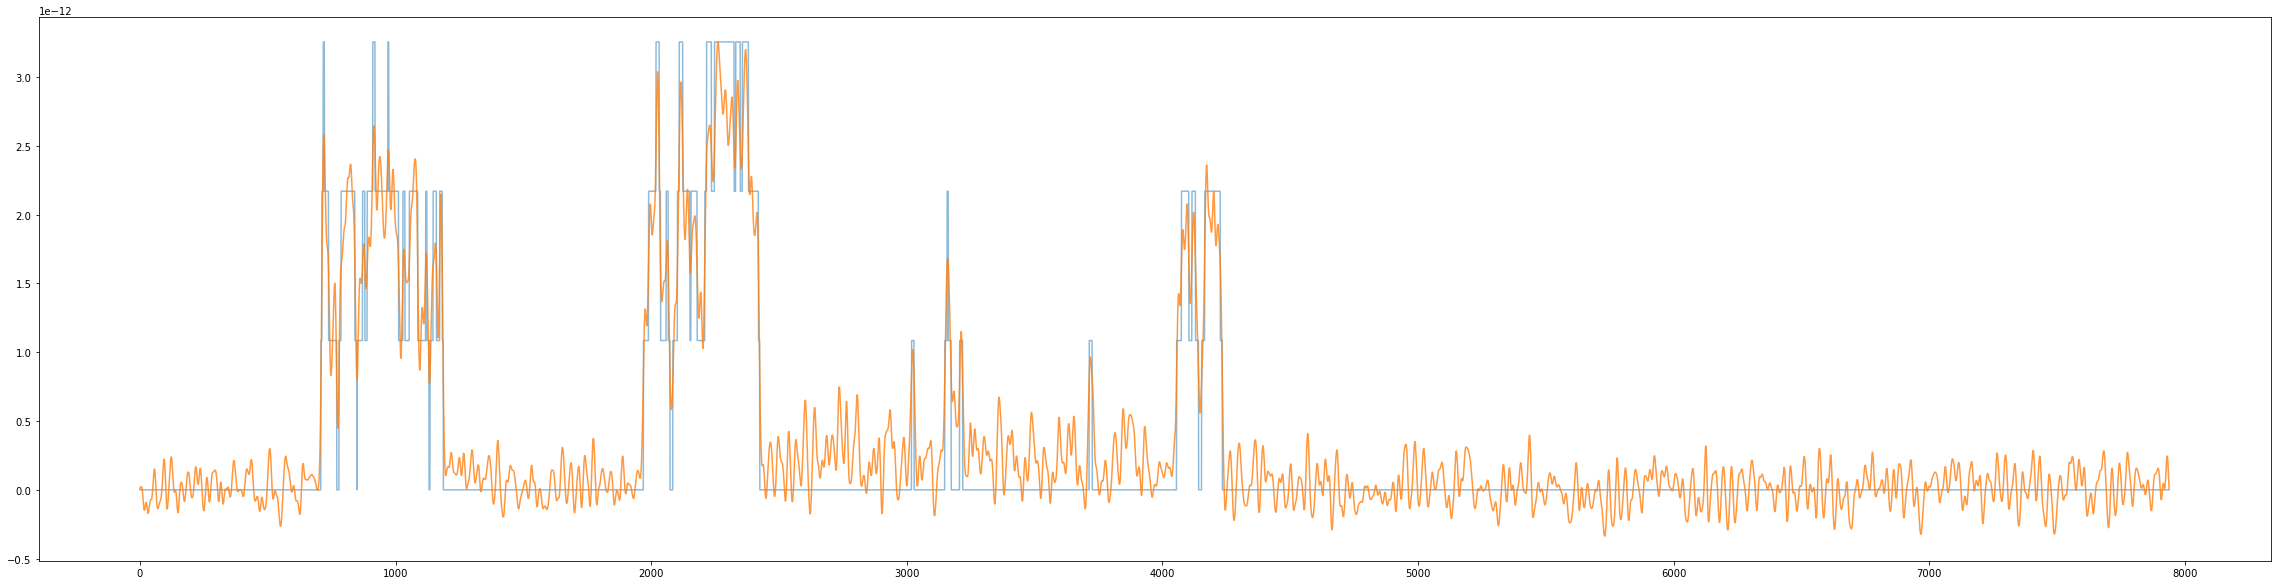

In [192]:
plt.figure(figsize=(40,10))
plt.plot(ideal*sm,alpha = .5)
plt.plot(-signal,alpha=.8)

In [193]:
### add noise to idealized signal:
##seperate different levels
mask = []
for i in range(4):
    m = ideal == i/3
    mask.append(m)
## get mean and variance of signal at each level
std = []
mean = []
#at this point we can use the means of the different levels of the hypothetical n/3 of maximum amplitude by which they where seperated
for i in range(4):
    m = np.mean(original[mask[i]])
    mean.append(m)    
    v = np.std(original[mask[i]])
    std.append(v)
## simulate noise and add to idealized signal
noisy = np.zeros(len(ideal))
for i in range(4):
    noise = np.random.normal(loc=mean[i],scale=std[i],size=np.sum(mask[i]))
    noisy[mask[i]] = noise


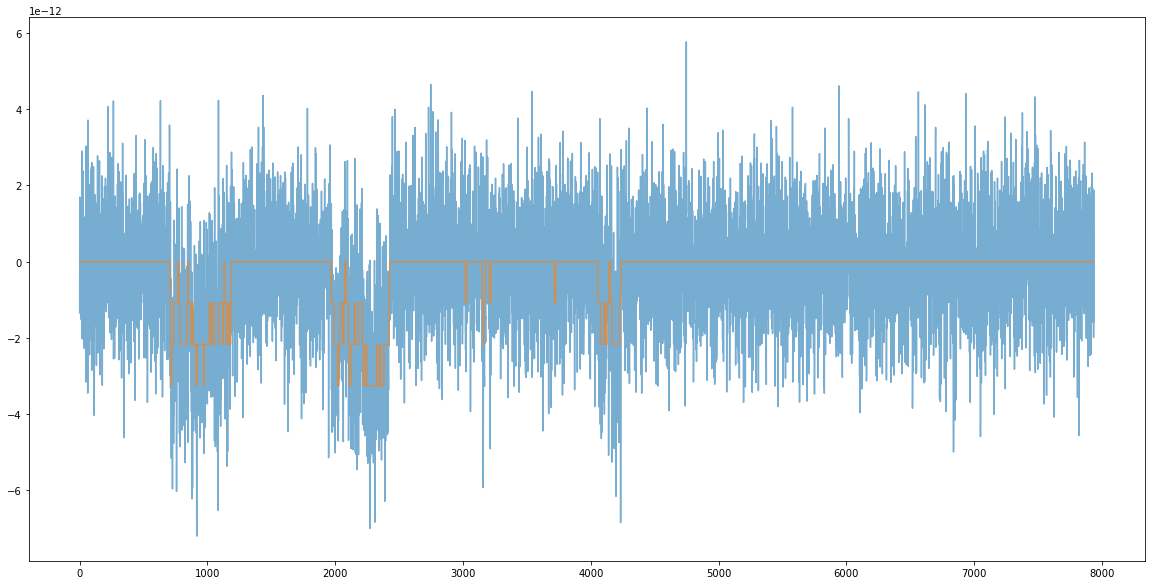

In [194]:
plt.figure(figsize=(20,10))
plt.plot(noisy,alpha=.6)
plt.plot(-sm*ideal,alpha=.6)

In [195]:
fc, fs, = 1e3, 4e4
fcs = fc/fs
window = Gaussian(fcs)
filtered = apply_filter(noisy,window)

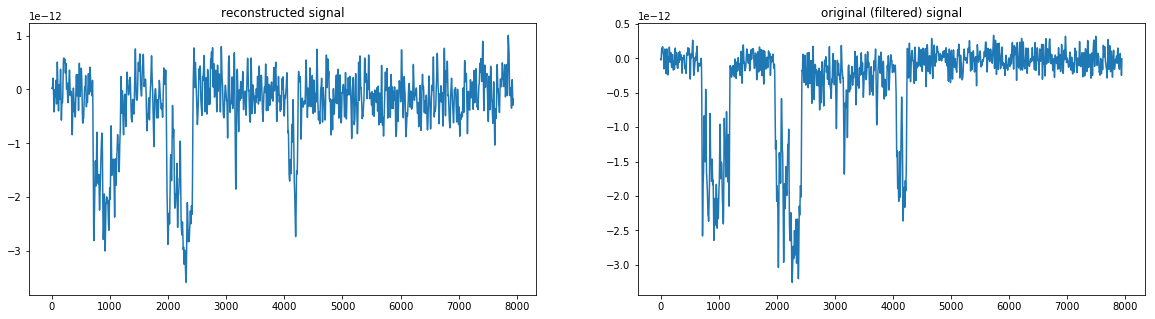

In [196]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(filtered)
plt.title('reconstructed signal')
plt.subplot(122)
plt.plot(signal)
plt.title('original (filtered) signal')

In [26]:
def ssd(x,y):
    return np.sum(np.square(x-y))

In [108]:
def eval_numerical_gradient(f, x):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 0.00001
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h # increment by h
        fxh = f(x) # evalute f(x + h)
        x[ix] = old_value # restore to previous value (very important!)
        grad[ix] = (fxh - fx) / h # the slope
        it.iternext() # step to next dimension
    return grad

In [109]:
def loss(signal,thetas):
    ideal, sm = multilevel_threshold(signal,thetas)
    ### add noise to idealized signal:
    ##seperate different levels
    mask = []
    for i in range(4):
        m = ideal == i/3
        mask.append(m)
    ## get mean and variance of signal at each level
    std = []
    mean = []
    #at this point we can use the means of the different levels of the hypothetical n/3 of maximum amplitude by which they where seperated
    for i in range(4):
        if np.sum(mask[i]) is not 0:
            m = np.mean(original[mask[i]])
            mean.append(m)    
            v = np.std(original[mask[i]])
            std.append(v)
        else:
            mean.append(0)
    ## simulate noise and add to idealized signal
    noisy = np.zeros(len(ideal))
    for i in range(4):
        noise = np.random.normal(loc=mean[i],scale=std[i],size=np.sum(mask[i]))
        noisy[mask[i]] = noise
    fc, fs, = 1e3, 4e4
    fcs = fc/fs
    window = Gaussian(fcs)
    filtered = apply_filter(noisy,window)
    difference = ssd(filtered,signal)
    return difference

In [110]:
from functools import partial
loss_train = partial(loss, signal)

In [204]:
# thetas = np.linspace(0,1,5)[:-1]*np.max(np.abs(signal))
thetas = np.random.uniform(0,1*np.max(np.abs(signal)),size=4)
dE = 1
eta = .5
l_old = loss_train(thetas)
i = 1
while dE>1e-4:
#     print('step ',i)
    i+=1
    df = eval_numerical_gradient(loss_train, thetas)
    thetas-= eta*df
    l_new = loss_train(thetas)
    dE = np.abs(l_new-l_old)/l_old
    l_old = l_new
    eta*=.95
#     print('current dE%.2d'%dE)
print('finished after %.d steps' %i)

/home/dpenguin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/dpenguin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dpenguin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/dpenguin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/dpenguin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finished after 299 steps


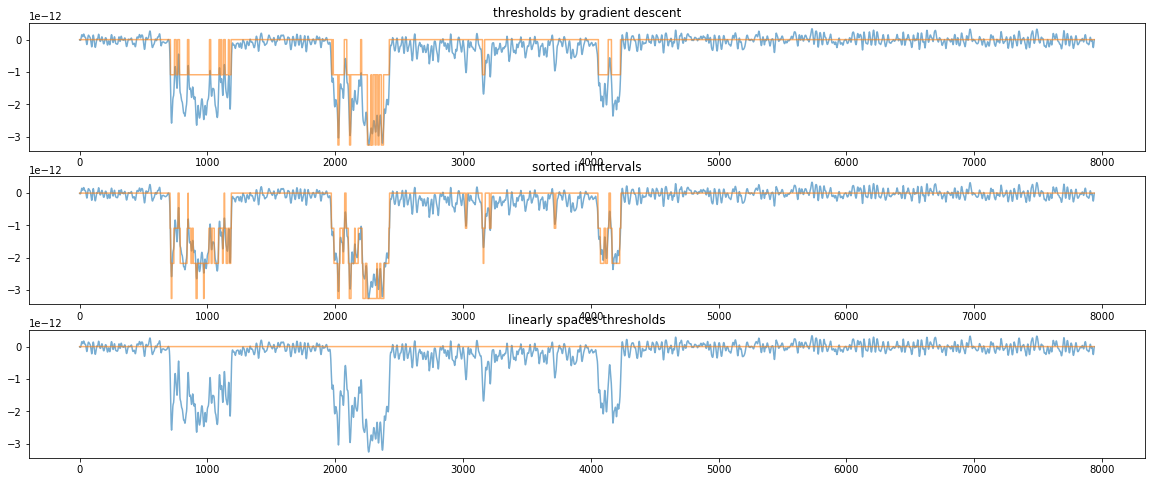

In [218]:
plt.figure(figsize=(20,8))
ideal, sm = multilevel_threshold(signal,thetas)
plt.subplot(311)
plt.plot(signal,alpha=.6)
plt.plot(-ideal*sm,alpha=.6)
plt.title('thresholds by gradient descent')
plt.subplot(312)
ideal, sm = multilevel_threshold(signal,np.linspace(0,1,5)[:-1]*np.max(np.abs(signal)))
plt.plot(signal,alpha=.6)
plt.plot(-ideal*sm,alpha=.6)
plt.title('sorted in intervals')
plt.subplot(313)
ideal, sm = tc(signal,t)
plt.plot(signal,alpha=.6)
plt.plot(-ideal*sm,alpha=.6)
plt.title('linearly spaces thresholds')

In [216]:
thetas, t, np.linspace(0,1,5)[:-1]*np.max(np.abs(signal))

(array([  1.67174182e-12,   1.22947357e-12,   2.75433413e-12,
          2.68228614e-12]),
 array([  5.42682100e-13,   1.62804630e-12,   2.71341050e-12]),
 array([  0.00000000e+00,   8.14023150e-13,   1.62804630e-12,
          2.44206945e-12]))

In [207]:
t = np.array([1/6,1/2,5/6])*np.max(np.abs(signal))

In [217]:
def tc(signal,t):
    ideal = np.zeros(len(signal))
    sm = np.max(np.abs(signal))
    for i in range(len(signal)):
        if signal[i]>t[0]:
            ideal[i] = 1/3w
        elif signal[i]>t[1]:
            ideal[i] = 2/3
        elif signal[i]>t[2]:
            ideal[i] = 1
    return ideal, sm

In [36]:
bn = 'sim1600.bin'
bp = '/home/dpenguin/Documents/work/Code/detection'
bt = np.int16
bh = 3072
n, t, d = load_binary(bp,bn,bt,bh,4e4)

In [116]:
rec = Recording(filename=bn,filepath=bp,filetype='bin',headerlength=bh,bindtype=bt)

In [130]:
def visual_compare(recording, dataKey = 'raw', epochnumber = 0, tstart = 0, tend = 5000):
    """
    This function generates a plot comparing the idealized trace to the original trace
    """
    fig = plt.figure(figsize=(20,8))
    time = recording.data[dataKey][epochnumber].time[tstart:tend]
    signal = recording.data[dataKey][epochnumber].currentTrace[tstart:tend]
    ideal = recording.data[dataKey+'_TC'][epochnumber].currentTrace[tstart:tend]
    plt.plot(time, signal, label='unfiltered data',alpha=.8)
    plt.plot(time, ideal, label='idealization', alpha =.7)
    plt.xlabel('time [ms]')
    plt.xticks(np.arange(tstart,tend))
    plt.ylabel('current [A]')
    plt.show()

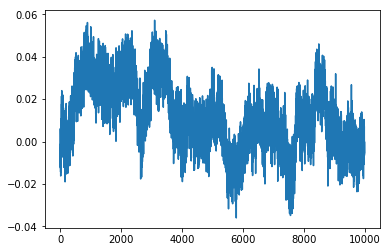

In [174]:
### generate some 1+1/f noise
f_val = 300
length = 1e4 
f = np.arange(1,length)
r = np.random.uniform(-1,1,size=len(f))
i = np.random.uniform(-1,1,size=len(f))
rp = r*(1+f_val/f)
ip = i*(1+f_val/f)
p = rp+1j*ip
noise = np.fft.ifft(p)
plt.plot(np.real(noise))